# 11. Regelungstechnik
Einfache Simulation und Regelung eines Systems mittels Python und Numpy

### Ziel: Erstellung einer einfachen Simulation eines mechanischen Modelles und Entwurf eine geeigneten PID-Regelrs für dieses System

## Vorgehen:
* 1. Modellbildung
* 2. Simulation
* 3. Reglerdesign
* 4. Optimierung des Reglers

## Start: Einbinden der benötigten Libraries

In [2]:
# Numerical library
import numpy as np

# Visualization library
import matplotlib.pyplot as plt

# Interactive library
import ipywidgets as widgets

# 1. Modellbildung

![](./img/strecke.png)

Wir wollen das System simulieren.

Wie? 
Indem wir die Systemänderung (=Ableitung) beschreiben können!

$$ \bf{x}_{t+1} = \bf{x}_{t} + \Delta t \frac{\delta \bf{x}}{\delta t}$$

## Differentialgleichung der Regelstrecke

$$ m \ddot{x} + d \dot{x} + c{x} = F$$

Diese soll nun in die Form:
$$ \dot{\bf{x}} = \bf{A} \bf{x} + \bf{b}  u$$
umformuliert werden.

### 1.1 Zustandsvektor so formulieren, dass höchste Ableitung durch Zustandsvektor darstellbar ist:

$$ \bf{x} = \begin{pmatrix}x\\\dot{x}\end{pmatrix},   \bf{\dot{x}} = \begin{pmatrix}\dot{x}\\\ddot{x}\end{pmatrix} $$

### 1.2 Die Stellgröße u definieren:

$$ u = F $$

### 1.3 Die Differentialgleichung nach der höchsten Ableitung umformulieren:
$$ m \ddot{x} + d \dot{x} + c{x} = F$$

$$ \ddot{x} = - \frac{c}{m} x - \frac{d}{m} \dot{x} + \frac{1}{m} F$$

### 1.4 Das Gleichungssystem für die Vektorschreibweise ausformulieren:

$$ \begin{pmatrix}\dot{x}\\\ddot{x}\end{pmatrix} = \begin{pmatrix} 0 &1 \\ -\frac{c}{m} &-\frac{d}{m}\end{pmatrix}
\begin{pmatrix}x\\\dot{x}\end{pmatrix} + \begin{pmatrix}0\\\frac{1}{m}\end{pmatrix} F
$$

### 1.5 Die erhaltene Matrix A und Vektor b notieren:

$$ \bf{A} = \begin{pmatrix} 0 &1 \\ -\frac{c}{m} &-\frac{d}{m}\end{pmatrix}, \bf{b} = \begin{pmatrix}0\\\frac{1}{m}\end{pmatrix} $$

In [3]:
def get_A_b(m, d, c):
    """
    Function defining the System matrix of the Ode Problem:
    m * ddx + d * dx + c * x = F
    """
    # System matrix A # ToDO
    A = np.matrix([
        [0, 0],
        [0, 0]
    ])  
    # Activation vector b
    b = np.array([
        0, 0
    ])
    return A, b

### 1.6 Good practice: Test it!

$$ \bf{A} = \begin{pmatrix} 0 &1 \\ -\frac{c}{m} &-\frac{d}{m}\end{pmatrix}, \bf{b} = \begin{pmatrix}0\\\frac{1}{m}\end{pmatrix} $$

In [4]:
m = 1
d = 2
c = 3

A, b = get_A_b(m=m, d=d, c=c)
A, b

(matrix([[0, 0],
         [0, 0]]), array([0, 0]))

### 1.7 Berechne Ableitung

$$ \dot{\bf{x}} = \bf{A} \bf{x} + \bf{b}  u$$

In [5]:
def get_derivative(A, b, x_vec, u):
    """"""
    # dx = A*x + b*u
    dxdt = np.matmul(A, x_vec) + b * u
    # transform to array
    dxdt = np.squeeze(np.asarray(dxdt))
    return dxdt

# Test:
dxdt = get_derivative(A, b, [0., 0.], 1)
dxdt

array([0., 0.])

### 1.8 Zusammenfassung der Differentialgleichung in einer Klasse

In [6]:
class Ode_Model(object):
    """
    Class containing all information about the linear ODE Problem
    """
    
    def __init__(self, controller):
        """Initialise the ODE object"""
        # Parameter definitions
        self.set_physical_params()
        # Set the controller
        self.controller = controller
        # reset 
        self.reset()
    
    def set_physical_params(self, mass=1, damping=1, stiffness=1):
        """set the system parameters"""
        self.mass = mass # kg
        self.damping = damping # kg/s
        self.stiffness = stiffness # kg/s²
        
        # update the System components A and b:
        self.set_A_b()
    
    def set_A_b(self, eps=1e-6):
        """Set the system configuration"""       
        # System matrix A
        self.A = np.matrix([
            [0., 1.],
            [-self.stiffness / (self.mass + eps), -self.damping / (self.mass + eps)]
        ])     
        # Activation vector b
        self.b = np.array(
            [0, 1
        ])
    
    def reset(self):
        """reset the system for new simulation"""
        self.last_t = 0
        self.controller.reset()
        
    def __call__(self, x_vec, dt):
        """Main function call, which returns the derivative"""
        # Get the control force u
        u = self.controller(x_vec, dt)
        
        # Calculate the derivative using
        # dx = A * x + b * u
        dxdt = np.matmul(self.A, x_vec) + self.b * u
        
        # return as array
        return np.squeeze(np.asarray(dxdt))

## 2. Simulation des Modells

Bevor der Regler entworfen wird ist es wichtig das Verhalten des Systems zu verstehen.

Daher ist es von Vorteil das System simulieren zu können.

### 2.1 Anwendung der einfachen Forwärts Euler Integration:
$$ \bf{x}_{t+1} = \bf{x}_{t} + \Delta t \frac{\delta \bf{x}}{\delta t}$$

In [7]:
def euler_integrator(x0, A, b, t0=0, tf=10, dt=0.05):
    # time vector
    tt = np.arange(t0, tf + dt, dt)
    # init the trajectory
    x_traj = np.zeros([tt.shape[0], 2])
    
    # iterate through the vector
    for i, t in enumerate(tt):
        x_traj[i, :] = x0
        u = 0
        dxdt = get_derivative(A=A, b=b, x_vec=x0, u=u)
        # update with euler
        x0 += dxdt * dt
        
    return tt, x_traj

### 2.2 Teste Ergebnis
$$ m \ddot{x} + d \dot{x} + c{x} = 0$$

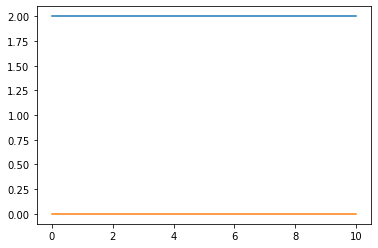

In [8]:
x0 = [2, 0]
tt, x_traj = euler_integrator(x0, A, b)
plt.plot(tt, x_traj)

### 2.3 Zusammenfassung der Integrators in einer Klasse

In [9]:
class Euler_Simulator(object):
    """class containing general simulator information"""
    
    def __init__(self, system):
        """setup for simulator"""
        self.set_simulation_params()
        self.system = system
        
    def set_simulation_params(self, t0=0, tf=10, dt=0.05):
        """set the simulation parameters"""
        self.t0, self.tf, self.dt = t0, tf, dt
    
    def __call__(self, x0):
        """perform the simulation"""
        # reset before simulation
        self.system.reset()
        
        # time vector
        tt = np.arange(self.t0, self.tf + self.dt, self.dt)
        
        # init the trajectory
        x_traj = np.zeros([tt.shape[0], 2])
        
        # iterate through the vector
        for i, t in enumerate(tt):
            x_traj[i, :] = x0
            
            dxdt = self.system(x0, self.dt)
            x0 += dxdt * self.dt
        
        return x_traj

### 2.4 Interaktive Visualisierung der Systemparameter mit "Widgets"
Ziel: Systemparameter besser begreifbar machen

In [10]:
# Import Library
import ipywidgets as widgets

# Create Widget
demo = widgets.FloatSlider(min=0, max=10, value=1, description='Demo:')

# Define update Function
def update_demo(argument):
    print(argument)
    
# make it interactive
widgets.interactive(update_demo, argument=demo)

interactive(children=(FloatSlider(value=1.0, description='Demo:', max=10.0), Output()), _dom_classes=('widget-…

### Wir wollen also die Systemparameter visualisieren und benötigen dafür die entsprechende Widgets

In [23]:
# System parameters
m = widgets.FloatSlider(min=0, max=10, value=1, description='Mass:')
d = widgets.FloatSlider(min=0, max=10, value=1, description='Damping:')
c = widgets.FloatSlider(min=0, max=10, value=1, description='Stiffness:')

# Initial values
pos_0 = widgets.FloatSlider(min=-5, max=5, value=0, description='Position_0:')
vel_0 = widgets.FloatSlider(min=-5, max=5, value=0, description='Velocity_0:')

### Um unser Model initialisieren zu können brauchen wir eine Dummy Klasse für den Controller

```python
class Ode_Model(object):
    
    def __init__(self, controller):
        """Initialise the ODE object"""
        self.controller = controller
```

In [12]:
class Zero_Controller(object):
    
    def __init__(self):
        self.set_target()
        
    def reset(self):
        pass
    
    def set_target(self, target=1):
        """Set the desired position"""
        self.target = target

    def __call__(self, x_vec, dt):
        return 0

### Initialisiere die Objekte: Model, Controller und Simulator

In [24]:
# setup the objects
zero_control = Zero_Controller()
model = Ode_Model(controller=zero_control)
sim = Euler_Simulator(model)

# vectors for plotting
t = np.arange(sim.t0, sim.tf + sim.dt, sim.dt)
x_des = np.ones(t.shape) * zero_control.target

### Die Update Funktion

In [25]:
def update_model(pos_0, vel_0, m, d, c):
    """
    updating fucntion which we will call from the widgets
    """
    # set the desired parameters
    model.set_physical_params(mass=m, damping=d, stiffness=c)
    x0 = [pos_0, vel_0]
    x_traj = sim(x0)
    
    # plot the results
    visualize_results(t, x_traj, x_des)

### Darstellung der Ergebnisse

In [15]:
def visualize_results(t, x_traj, x_des, figsize=(10,6)):
    """function to visualize all results"""
    fig = plt.figure(figsize=figsize)
    plt.plot(t, x_traj[:, 0], label='position')
    plt.plot(t, x_traj[:, 1], label='velocity')
    plt.plot(t, x_des, 'r--', label='x_des')
    plt.grid(0.1)
    plt.ylim([-2, 5])
    plt.legend()
    plt.xlabel('time in s')
    plt.ylabel('x')
    plt.show()

## Interaktive Modellparameter

In [16]:
widgets.interactive(update_model, pos_0= pos_0, vel_0=vel_0, m=m, d=d, c=c)

interactive(children=(FloatSlider(value=0.0, description='Position_0:', max=5.0, min=-5.0), FloatSlider(value=…

## 3. Entwurf des Proportinal, Integral, Differenzial Reglers (PID- Regler)
![](./img/PID.png)

## 3.1 Warum P-Anteil nicht ausreichend? -- Probieren wir es doch aus!

In [17]:
class P_Controller(object):
    
    def __init__(self):
        self.set_target()
        
    def reset(self):
        pass
    
    def set_target(self, target=1):
        """Set the desired position"""
        self.target = target
    
    def set_params(self, K_p=1):
        """set and reset the controller parameters"""
        self.K_p = K_p

    def __call__(self, x_vec, dt):
        # current system vector
        x, dx = x_vec
        # err
        err = self.target - x
        # u
        u = self.K_p * err
        return u

### ... und machen es interaktiv!

In [26]:
# create widget
K_p = widgets.FloatSlider(min=0, max=10, value=0, description='P:')

# Setup the objects
controller = P_Controller()
system = Ode_Model(controller)
sim = Euler_Simulator(system)


def update_P(K_p):
    """linked function"""
    # perform calculation
    controller.set_params(K_p=K_p)
    x_traj = sim(x0)
    # visualize result
    visualize_results(t, x_traj, x_des)

In [19]:
widgets.interactive(update_P, K_p=K_p)

interactive(children=(FloatSlider(value=0.0, description='P:', max=10.0), Output()), _dom_classes=('widget-int…

## 3.2 Erweiterung auf den PID Controller

In [20]:
class PID_Controller(object):
    """
    Class containing all relevant information for the PID controller
    """
    
    def __init__(self):
        """set all attributes of the controller"""
        self.set_params()
        self.set_target()
        self.reset()
    
    def set_params(self, K_p=1, K_i=1, K_d=1):
        """set and reset the controller parameters"""
        self.K_p, self.K_i, self.K_d = K_p, K_i, K_d
    
    def set_target(self, target=1):
        """Set the desired position"""
        self.target = target
        
    def reset(self):
        """Reset the control errors"""
        self.int_err = 0
        self.last_err = 0

    def __call__(self, x_vec, dt):
        """
        The control function with the PID control:
        - Proportional Difference
        - Integral Difference
        - Differential Difference
        """
        # current system vector
        x, dx = x_vec
        
        # calculate current error
        # P-Part
        err = self.target - x
        p_part = self.K_p * err
        
        # calculate the integral error
        # I-Part
        self.int_err += dt * err
        i_part = self.K_i * self.int_err
        
        # calculate the difference error using temporal differences
        # D-Part
        diff_err = (err - self.last_err) / dt
        d_part = self.K_d * diff_err
        
        # update last err
        self.last_err = err 
        
        # Sum the parts together
        u = p_part + i_part + d_part
        return u

In [27]:
# Setup the objects
controller = PID_Controller()
system = Ode_Model(controller)
sim = Euler_Simulator(system)

# initial state
x0 = [0, 0]
x_traj = sim(x0)

# vectors for plotting
t = np.arange(sim.t0, sim.tf + sim.dt, sim.dt)
x_des = np.ones(t.shape) * controller.target

def update_controls(K_p, K_i, K_d):
    """
    linked function to sliders and replots
    """
    # perform calculation
    controller.set_params(K_p=K_p, K_i=K_i, K_d=K_d)
    x_traj = sim(x0)
    # visualize result
    visualize_results(t, x_traj, x_des)

K_p = widgets.FloatSlider(min=0, max=10, value=0, description='P:')
K_i = widgets.FloatSlider(min=0, max=10, value=0, description='I:')
K_d = widgets.FloatSlider(min=0, max=10, value=0, description='D:')

## 4. Optimierung des PID-Reglers

In [22]:
widgets.interactive(update_controls, K_p=K_p, K_i=K_i, K_d=K_d)

interactive(children=(FloatSlider(value=0.0, description='P:', max=10.0), FloatSlider(value=0.0, description='…

## Versuche die Tabelle auszufüllen mit Hilfe der Visualisierung!
![](./img/tabular.png)